Abgabe von: Mat.Nr.: 9452857 & 1113800

Before doing anything installing all needed dependencies

!pip3 install pandas
!pip3 install scikit-learn
!pip3 install tensorflow
!pip3 install matplotlib

# Aufgabe 1

In [14]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Import data

In [15]:
white_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-white.csv", delimiter=";")
red_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-red.csv", delimiter=";")

In [38]:
white_raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Split wine in Test and Training Data (75% / 25%)

In [16]:
white_training_Data, white_test_data, white_training_scores, white_test_scores = (train_test_split(white_raw.drop("quality", axis=1), white_raw['quality'],test_size=0.25, random_state=39))

red_training_Data, red_test_data, red_training_scores, red_test_scores = (train_test_split(red_raw.drop("quality", axis=1), red_raw['quality'],test_size=0.25, random_state=39))

In [17]:
white_training_Data = np.array(white_training_Data)
red_training_Data = np.array(red_training_Data)

In [18]:
white_training_Data

array([[ 7.3 ,  0.38,  0.23, ...,  3.1 ,  0.55, 11.2 ],
       [ 6.3 ,  0.33,  0.2 , ...,  3.14,  0.51,  8.8 ],
       [ 7.4 ,  0.41,  0.66, ...,  3.05,  0.46,  8.7 ],
       ...,
       [ 7.4 ,  0.2 ,  0.37, ...,  3.03,  0.42,  9.2 ],
       [ 7.3 ,  0.13,  0.32, ...,  3.2 ,  0.35,  9.2 ],
       [ 6.8 ,  0.19,  0.34, ...,  3.25,  0.45, 12.9 ]])

# Aufgabe 3

https://www.tensorflow.org/tutorials/keras/regression#regression_using_a_dnn_and_multiple_inputs

In [29]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [30]:
#input_layer = layers.Input(shape=(1, 11))
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(white_training_Data)

In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [58]:
model = keras.Sequential([
  normalizer,
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001))


In [59]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 11)             │            23 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23 (96.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23 (96.00 B)

In [60]:
%%time
history = model.fit(
    white_training_Data,
    white_training_scores,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 1.44 s
Wall time: 8.82 s


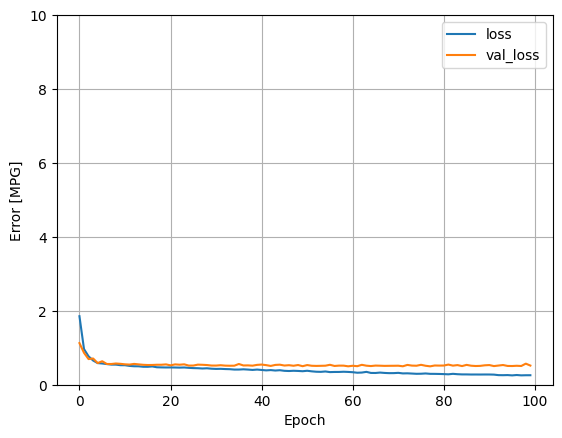

In [61]:
plot_loss(history)

In [62]:
test_results = model.evaluate(
    white_test_data, white_test_scores,
    verbose=0)


In [63]:
print(f'Mean absolute error [winequality-white]: {test_results}')

Mean absolute error [winequality-white]: 0.5777888894081116


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


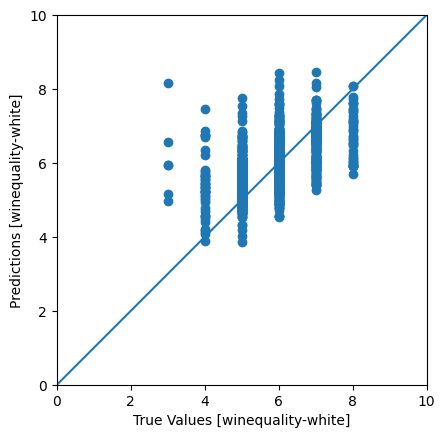

In [64]:
test_predictions = model.predict(white_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(white_test_scores, test_predictions)
plt.xlabel('True Values [winequality-white]')
plt.ylabel('Predictions [winequality-white]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

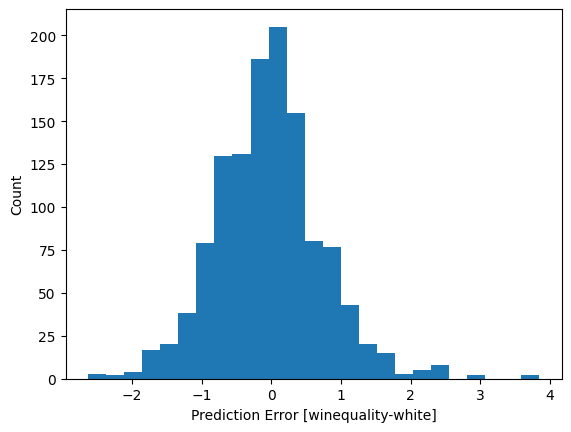

In [43]:
error = test_predictions - white_test_scores
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [winequality-white]')
_ = plt.ylabel('Count')